In [1]:
import nibabel as nib
import nilearn as nil
import numpy as np
import pandas as pd
import os
import os.path
import logging
from nilearn import plotting, image
import radiomics
from radiomics import featureextractor
from src.utils.data import getDataPandas, getPandas

In [2]:
data = getDataPandas()
mask_path = 'bin/raal3.nii'
mask_template = nib.load(mask_path).get_fdata().astype(int)
mask_tags = {
    'lCAU': [75],
    'rCAU': [76],
    'lPUT': [77],
    'rPUT': [78],
    'rSN': [162, 164],
    'lSN': [161, 163],
    'lTHA': [121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149],
    'rTHA': [122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150]
    #'thalamus': [121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
}
#mask[np.isin(mask_template, mask_tags['caudate nucleus'])] = 1
#mask[np.isin(mask_template, mask_tags['putamen'])] = 2
#mask[np.isin(mask_template, mask_tags['substantia nigra'])] = 3
#mask[np.isin(mask_template, mask_tags['thalamus'])] = 4

d:\scoop\apps\pyenv\current\pyenv-win\versions\3.8.10\lib\site-packages\nilearn\plotting\html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
d:\scoop\apps\pyenv\current\pyenv-win\versions\3.8.10\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



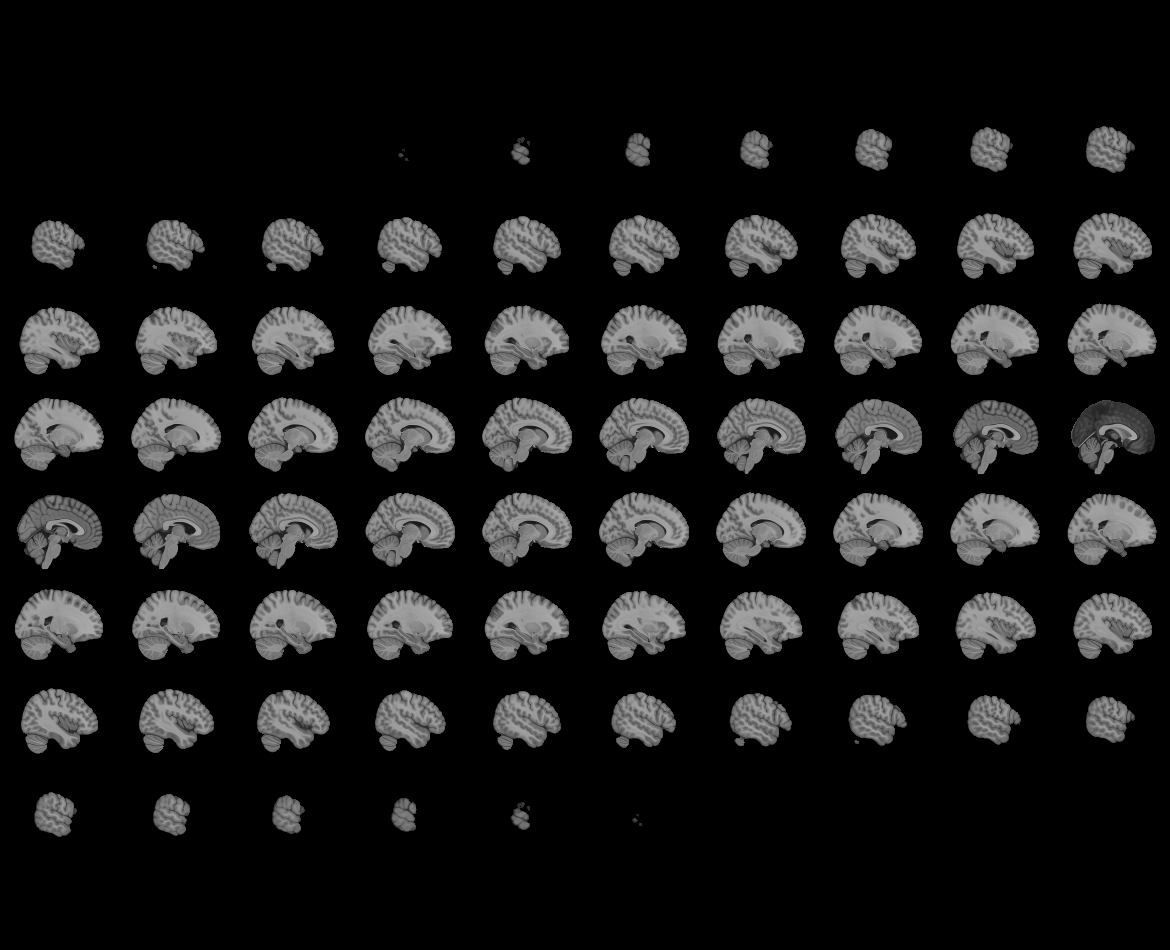
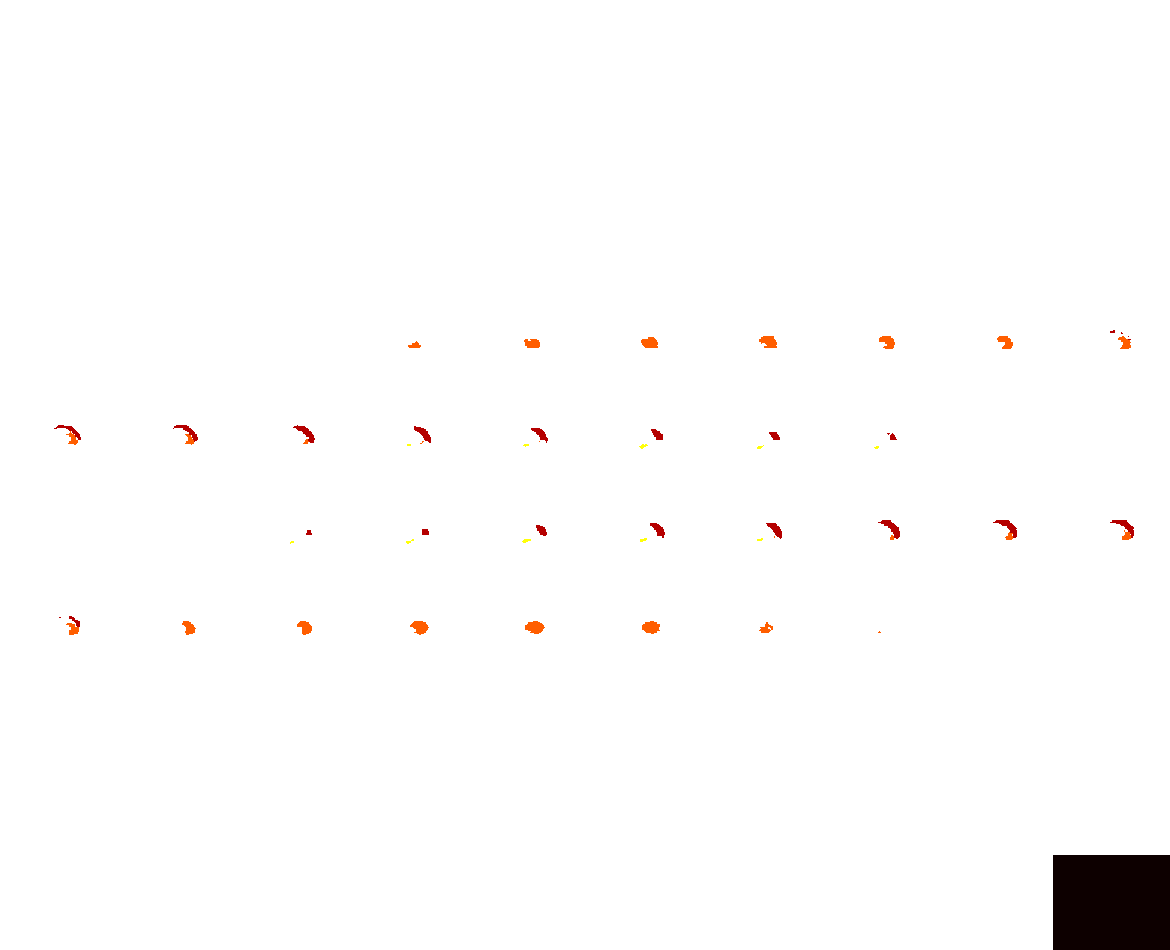

In [3]:
mask = np.zeros_like(mask_template)
mask[np.isin(mask_template, mask_tags['lCAU'])] = 1
mask[np.isin(mask_template, mask_tags['rCAU'])] = 1
mask[np.isin(mask_template, mask_tags['lPUT'])] = 2
mask[np.isin(mask_template, mask_tags['rPUT'])] = 2
mask[np.isin(mask_template, mask_tags['lSN'])] = 3
mask[np.isin(mask_template, mask_tags['rSN'])] = 3
mask[np.isin(mask_template, mask_tags['lTHA'])] = 4
mask[np.isin(mask_template, mask_tags['rTHA'])] = 4
p_img = image.new_img_like(mask_path, mask)
plotting.view_img(p_img, resampling_interpolation='nearest')

In [4]:
for tag, labels in mask_tags.items():
    mask = np.full(mask_template.shape, 0)
    for label in labels:
        mask[mask_template == label] = 1
    img = image.new_img_like(mask_path, mask)
    img.to_filename(os.path.join('bin', 'roi', tag + '.nii'))

In [50]:
radiomics.logger.setLevel(logging.ERROR)
extract = featureextractor.RadiomicsFeatureExtractor()
extract.loadParams(os.path.join('data', 'radiomic.yaml'))

In [6]:
def cal_radiomics(path):
    filtered_rst = {}
    for key in mask_tags.keys():
        rst = extract.execute(path, os.path.join('bin', 'roi', key + '.nii'))
        for k, v in rst.items():
            if ('firstorder' in k) or ('glcm' in k) or ('gldm' in k) or ('glrlm' in k) or ('glszm' in k):
            #if ('firstorder' in k):
                filtered_rst[key + '_' + k] = v
    return filtered_rst

In [7]:
rsts = list(map(cal_radiomics, data['T1_MNI_PATH']))

In [56]:
data_radiomic = pd.DataFrame(rsts)
data_radiomic = data_radiomic.astype(float)
data_radiomic['KEY'] = data['KEY']

In [9]:
import json
with open(os.path.join('data', 'json', 'data_radiomic_full.json'), 'w+', encoding="utf-8") as f:
        json.dump(data_radiomic.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from src.utils.data import getConfig

In [90]:
data_radiomic = getPandas('data_radiomic_full')
data_radiomic = data_radiomic[data_radiomic.columns.drop(list(data_radiomic.filter(regex='THA')))]
rad = data_radiomic.copy()
config = getConfig('data')
rad = rad.iloc[config['train_index']].drop(['KEY'], axis=1)

In [88]:
from sklearn.feature_selection import r_regression
y = data.iloc[config['train_index']][['SCORE']].to_numpy()
removal = []
for tag, labels in mask_tags.items():
    cor = rad.filter(like=tag, axis=1).corr()
    r = abs(r_regression(rad.filter(like=tag, axis=1), y.ravel()))
    cor = abs(cor)
    size = len(cor)
    for i in range(size):
        col = cor.iloc[:, i]
        for j in range(i):
            val = col.iloc[j]
            if val > 0.6:
                if (col.name in removal) or (cor.iloc[:, j].name in removal):
                    continue
                tmp = col.name if (r[i] < r[j]) else cor.iloc[:, j].name
                if not (tmp in removal):
                    removal.append(tmp)

In [91]:
from scipy.stats import spearmanr
y = data.iloc[config['train_index']][['CAT']].to_numpy()
removal = []
for tag, labels in mask_tags.items():
    cor = rad.filter(like=tag, axis=1).corr()
    p = []
    for fea_idx in range(len(rad.filter(like=tag, axis=1).columns)):
        p_val = abs(spearmanr(rad.filter(like=tag, axis=1).iloc[:,fea_idx], y.ravel()).pvalue)
        p.append(p_val)
    cor = abs(cor)
    size = len(cor)
    for i in range(size):
        col = cor.iloc[:, i]
        for j in range(i):
            val = col.iloc[j]
            if val > 0.7:
                if (col.name in removal) or (cor.iloc[:, j].name in removal):
                    continue
                tmp = col.name if (p[i] > p[j]) else cor.iloc[:, j].name
                if not (tmp in removal):
                    removal.append(tmp)

In [92]:
len(removal)

440

In [93]:
data_radiomic = data_radiomic.drop(removal, axis=1)

In [94]:
import json
with open(os.path.join('data', 'json', 'data_radiomic.json'), 'w+', encoding="utf-8") as f:
        json.dump(data_radiomic.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6400\3449672010.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data_radiomic.corr()


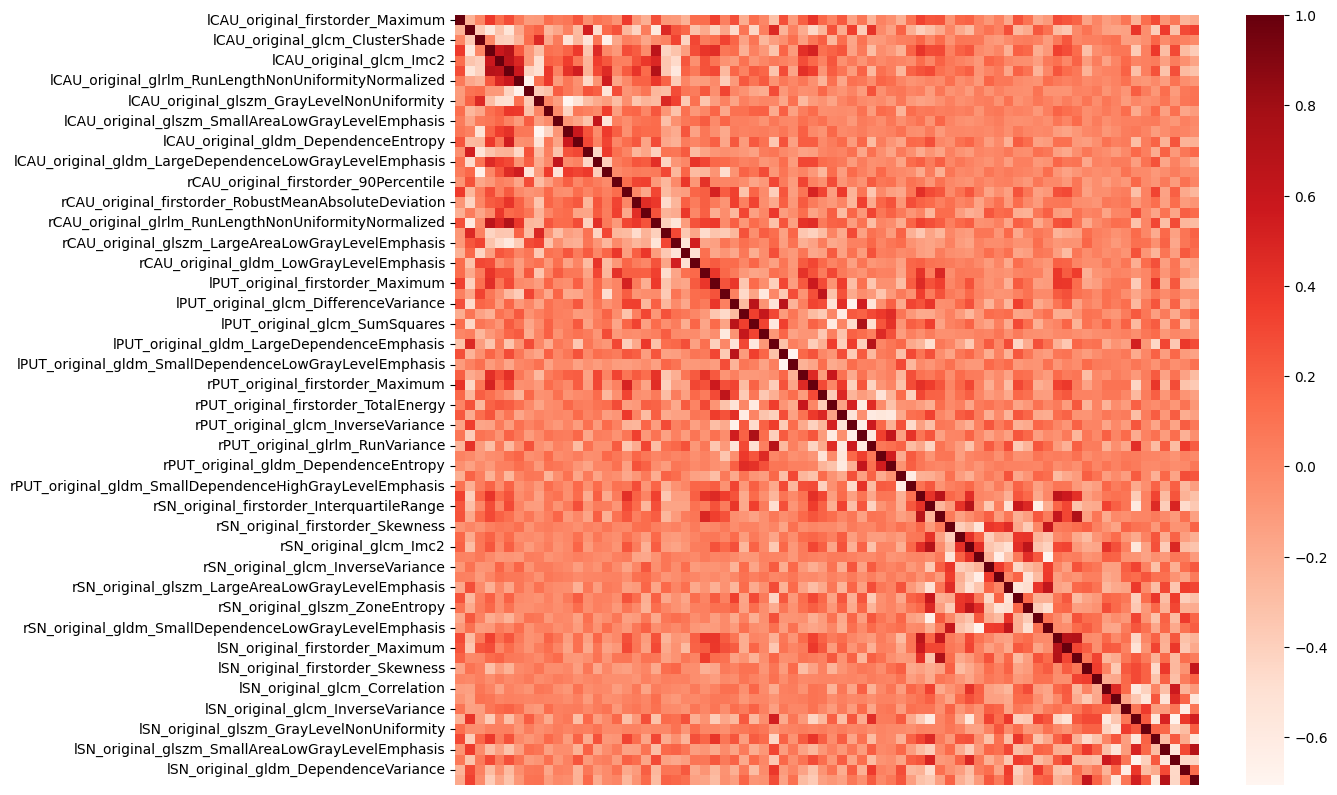

In [95]:
plt.figure(figsize=(12,10))
cor = data_radiomic.corr()
sns.heatmap(cor, cmap=plt.cm.Reds, xticklabels=False)
plt.show()

In [49]:
cor_target = abs(cor)
#cor_target.values[np.tril_indices_from(cor_target.values)] = np.nan
#cor_target = cor_target[cor_target < 0.8]
cor_target

,lCAU_original_firstorder_90Percentile,lCAU_original_firstorder_Maximum,lCAU_original_firstorder_Median,lCAU_original_firstorder_Range,lCAU_original_glcm_ClusterShade,lCAU_original_glcm_Correlation,lCAU_original_glcm_Imc2,lCAU_original_glcm_Idn,lCAU_original_glcm_MaximumProbability,lCAU_original_glcm_SumEntropy,...,rTHA_original_glszm_GrayLevelNonUniformity,rTHA_original_glszm_GrayLevelNonUniformityNormalized,rTHA_original_glszm_LargeAreaHighGrayLevelEmphasis,rTHA_original_glszm_LargeAreaLowGrayLevelEmphasis,rTHA_original_glszm_SizeZoneNonUniformity,rTHA_original_glszm_ZoneEntropy,rTHA_original_glszm_ZoneVariance,rTHA_original_gldm_DependenceEntropy,rTHA_original_gldm_DependenceVariance,rTHA_original_gldm_SmallDependenceLowGrayLevelEmphasis
lCAU_original_firstorder_90Percentile,1.000000,0.101648,0.727880,0.115235,0.367664,0.186512,0.106741,0.085521,0.252474,0.033537,...,0.120691,0.385479,0.002673,0.232176,0.361849,0.019556,0.270846,0.328851,0.203594,0.017089
lCAU_original_firstorder_Maximum,0.101648,1.000000,0.228539,0.589603,0.005328,0.372639,0.123669,0.255172,0.154150,0.283932,...,0.228124,0.354717,0.127388,0.382108,0.430750,0.146760,0.282397,0.213666,0.129256,0.278725
lCAU_original_firstorder_Median,0.727880,0.228539,1.000000,0.337328,0.362894,0.568919,0.327555,0.158642,0.198881,0.532870,...,0.120845,0.481692,0.147143,0.355179,0.506160,0.104880,0.262155,0.277939,0.126469,0.190879
lCAU_original_firstorder_Range,0.115235,0.589603,0.337328,1.000000,0.516859,0.371834,0.426432,0.007965,0.280562,0.689896,...,0.209210,0.247941,0.170665,0.287097,0.384885,0.299258,0.132783,0.062295,0.049312,0.207765
lCAU_original_glcm_ClusterShade,0.367664,0.005328,0.362894,0.516859,1.000000,0.006516,0.387094,0.341103,0.075864,0.399734,...,0.018777,0.114885,0.181011,0.028046,0.055359,0.181247,0.151022,0.150148,0.251659,0.098190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rTHA_original_glszm_ZoneEntropy,0.019556,0.146760,0.104880,0.299258,0.181247,0.036474,0.048245,0.057932,0.120949,0.226424,...,0.601351,0.094956,0.058993,0.046317,0.399159,1.000000,0.043186,0.169300,0.331205,0.033701
rTHA_original_glszm_ZoneVariance,0.270846,0.282397,0.262155,0.132783,0.151022,0.219622,0.066160,0.047224,0.033465,0.109773,...,0.583486,0.698089,0.298868,0.597061,0.700340,0.043186,1.000000,0.625949,0.781916,0.131323
rTHA_original_gldm_DependenceEntropy,0.328851,0.213666,0.277939,0.062295,0.150148,0.342306,0.088192,0.022257,0.019332,0.120706,...,0.118919,0.770364,0.026887,0.498997,0.612304,0.169300,0.625949,1.000000,0.329009,0.184423
rTHA_original_gldm_DependenceVariance,0.203594,0.129256,0.126469,0.049312,0.251659,0.015235,0.211781,0.164458,0.090720,0.127138,...,0.386276,0.396047,0.492675,0.242776,0.327429,0.331205,0.781916,0.329009,1.000000,0.037248
